In [63]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Save the model
import joblib

# Miscellaneous
import warnings
warnings.filterwarnings('ignore')  # to ignore warnings for clean output

In [64]:
# Load the dataset
df = pd.read_csv("Bengaluru_House_Data.csv")

# Copy original Dataframe. This will be used to generate bar chart of 'average house price per location'
df_original = df.copy()

# Show the first few rows
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [65]:
# Shape of the dataset (rows, columns)
print("Dataset shape:", df.shape)

# Information about columns, datatypes, nulls, etc.
df.info()

Dataset shape: (13320, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [66]:
# Total missing values per column
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [67]:
# Summary statistics for numerical columns
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [68]:
# Show column names and their types
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [69]:
# Unique values in selected columns
print("Unique values in 'area_type':", df['area_type'].unique())
print("Unique values in 'availability':", df['availability'].unique()[:10])  # show first 10
print("Unique values in 'size':", df['size'].unique()[:10])
print("Unique values in 'location':", df['location'].nunique(), "locations")

Unique values in 'area_type': ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
Unique values in 'availability': ['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep']
Unique values in 'size': ['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom']
Unique values in 'location': 1305 locations


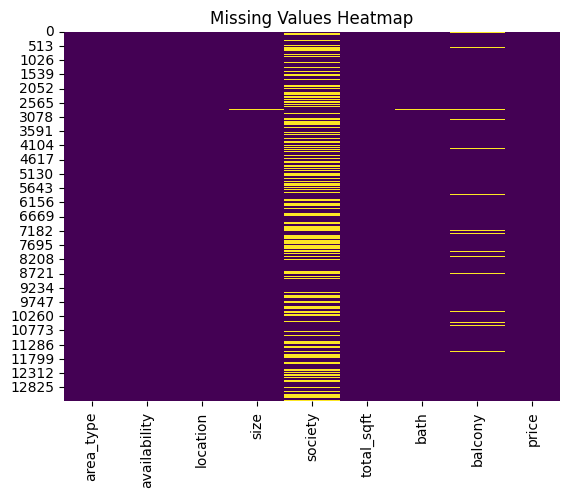

In [70]:
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [71]:
# Drop columns not useful for our model
df = df.drop(['society', 'availability', 'area_type'], axis=1)

In [72]:
# Drop rows with missing values in important columns
df = df.dropna()

In [73]:
# # Check if any missing values remain
print(df.isnull().sum())

# Updated shape
print("Updated dataset shape:", df.shape)

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64
Updated dataset shape: (12710, 6)


In [74]:
# Create a new column 'BHK' by extracting number from 'size'
df['BHK'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [75]:
def convert_sqft_to_num(x):
    try:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

# Apply conversion
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# Drop rows where conversion failed
df = df[df['total_sqft'].notnull()]

In [76]:
# Strip leading/trailing spaces
df['location'] = df['location'].apply(lambda x: x.strip())

# Group locations with less than 10 data points into 'other'
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [77]:
df = df.drop('size', axis=1)

In [78]:
# Store cleaned features before encoding
X_inputs = df[['total_sqft', 'bath', 'balcony', 'BHK', 'location']].copy()

In [79]:
# One-hot encode 'location' using pandas
dummies = pd.get_dummies(df['location'], drop_first=True)

# Add encoded columns to the main DataFrame
df = pd.concat([df, dummies], axis=1)

# Drop the original 'location' column
df = df.drop('location', axis=1)

In [80]:
print("Columns after encoding:")
print(df.columns)

print("\nDataset shape:", df.shape)

Columns after encoding:
Index(['total_sqft', 'bath', 'balcony', 'price', 'BHK', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Phase JP Nagar', '6th Phase JP Nagar',
       ...
       'Vishveshwarya Layout', 'Vishwapriya Layout', 'Vittasandra',
       'Whitefield', 'Yelachenahalli', 'Yelahanka', 'Yelahanka New Town',
       'Yelenahalli', 'Yeshwanthpur', 'other'],
      dtype='object', length=240)

Dataset shape: (12668, 240)


In [81]:
y = df['price']

In [82]:
X = df.drop('price', axis=1)

In [83]:
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (12668, 239)
Target shape: (12668,)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

In [ ]:
# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model on training data
lr_model.fit(X_train, y_train)

In [ ]:
print("Intercept:", lr_model.intercept_)
print("Coefficients:", lr_model.coef_)

In [ ]:
y_pred = lr_model.predict(X_test)

In [ ]:
# from sklearn.metrics import r2_score, mean_absolute_error

# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"R² Score: {r2:.4f}")
# print(f"Mean Absolute Error: {mae:.4f} lakhs")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # perfect prediction line
plt.xlabel("Actual Prices (lakhs)")
plt.ylabel("Predicted Prices (lakhs)")
plt.title("Actual vs Predicted House Prices")
plt.show()

In [ ]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
# print(f"Cross-validated R² scores: {scores}")
# print(f"Mean CV R² score: {scores.mean():.4f}")

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price (lakhs)")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='total_sqft', y='price', data=df, alpha=0.5)
plt.title("Price vs Total Square Feet")
plt.xlabel("Total Square Feet")
plt.ylabel("Price (lakhs)")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='BHK', y='price', data=df)
plt.title("Price vs Number of BHK")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
residuals = y_test - y_pred
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted Price)")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart: Average house price per location using original data
if 'location' in df_original.columns:
    avg_price_by_location = df_original.groupby('location')['price'].mean().sort_values(ascending=False).head(20)

    plt.figure(figsize=(12,6))
    sns.barplot(x=avg_price_by_location.values, y=avg_price_by_location.index, palette='viridis')
    plt.xlabel('Average Price (in Lakhs)')
    plt.ylabel('Location')
    plt.title('Top 20 Locations with Highest Average House Prices')
    plt.tight_layout()
    plt.show()
else:
    print("location column not found in df_original")

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f} lakhs")

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean CV R² score: {scores.mean():.4f}")

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(lr_model, 'house_price_model.pkl')

print("Model saved as 'house_price_model.pkl'")

In [ ]:
# Load the model from the file
loaded_model = joblib.load('house_price_model.pkl')

# Predict using the loaded model (example)
loaded_model.predict([X_test.iloc[0]])

In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load model
model = joblib.load('house_price_model.pkl')

# Example input
input_data = {
    'total_sqft': 2000,
    'bath': 2,
    'balcony': 2,
    'BHK': 2,
    'location': 'Whitefield'
}

In [ ]:
# Create a base input row with zeros for all columns
columns = X.columns  # This should be saved earlier or reloaded from disk
input_df = pd.DataFrame(data=np.zeros((1, len(columns))), columns=columns)

# Set the numerical features
input_df.at[0, 'total_sqft'] = input_data['total_sqft']
input_df.at[0, 'bath'] = input_data['bath']
input_df.at[0, 'balcony'] = input_data['balcony']
input_df.at[0, 'BHK'] = input_data['BHK']

# Handle location (one-hot encoding)
location_col = f"{input_data['location']}"
if location_col in input_df.columns:
    input_df.at[0, location_col] = 1
else:
    # Location is 'other' (we encoded rare ones this way)
    if 'other' in input_df.columns:
        input_df.at[0, 'other'] = 1

In [ ]:
# Create the actual vs predicted table using original features
comparison_df = pd.DataFrame({
    'Total Sqft': X_inputs.loc[X_test.index, 'total_sqft'].values,
    'Bath': X_inputs.loc[X_test.index, 'bath'].values,
    'Balcony': X_inputs.loc[X_test.index, 'balcony'].values,
    'BHK': X_inputs.loc[X_test.index, 'BHK'].values,
    'Location': X_inputs.loc[X_test.index, 'location'].values,
    'Actual Price (₹)': y_test.values,
    'Predicted Price (₹)': y_pred.astype(int)
})

# Display first 10 rows
comparison_df.head(10)

In [ ]:
# Predict
predicted_price = model.predict(input_df)[0]
print(f"Predicted house price: ₹{predicted_price:.2f} lakhs")